In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from typing import Callable, Union

In [6]:
x = sp.symbols("x")
y = sp.symbols("y")

f = 100 * (y - x**2)**2 + (1-x)**2
f.diff(y).diff(x)

-400*x

In [27]:
def rosenbrock(X, return_derivatives: bool = True):
    x1, x2 = X
    f = 100 * (x2 - x1**2)**2 + (1 - x1)**2

    if return_derivatives:
        df = np.array([-400*x1*(x2 - x1**2) + 2 * x1 - 2, 200*(x2 - x1 ** 2)])
        ddf = np.array([[1200*x1 ** 2 - 400*x2+2, -400*x1],[-400*x1,200]])
        return f, df, ddf
    return f

C:\Users\rasmu\AppData\Local\Temp\ipykernel_5792\4016307474.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ddf = np.array([[1200*x1 ** 2 - 400*x2+2, -400*x1],[-400*x1,200]])


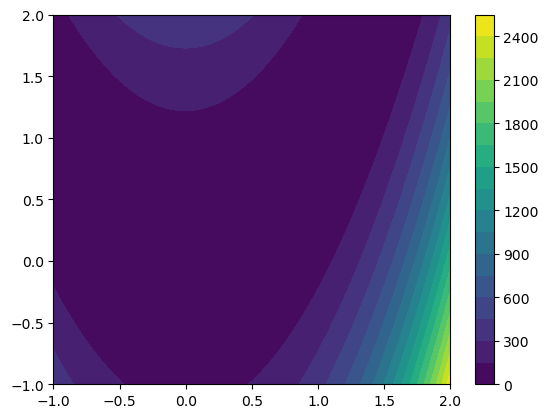

In [36]:
x = np.linspace(-1, 2, 1000)
y = np.linspace(-1, 2, 1000)

X, Y = np.meshgrid(x, y)

Z, _, _ = rosenbrock([X, Y], return_derivatives=True)

plt.contourf(X, Y, Z, levels=20)
plt.colorbar()
plt.show()

C:\Users\rasmu\AppData\Local\Temp\ipykernel_5792\3006460686.py:1: RuntimeWarning: divide by zero encountered in log
  plt.contourf(X,Y,np.log((Z)), levels=20)


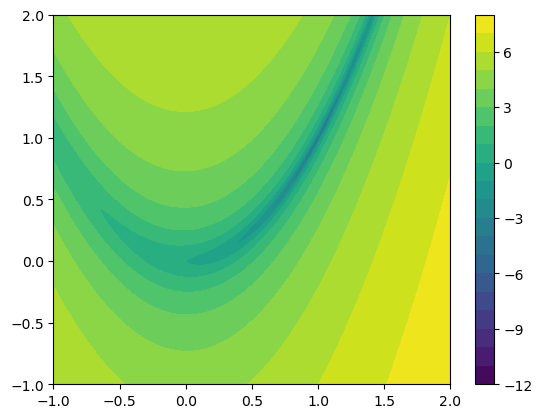

In [37]:
plt.contourf(X,Y,np.log((Z)), levels=20)
plt.colorbar()
plt.show()

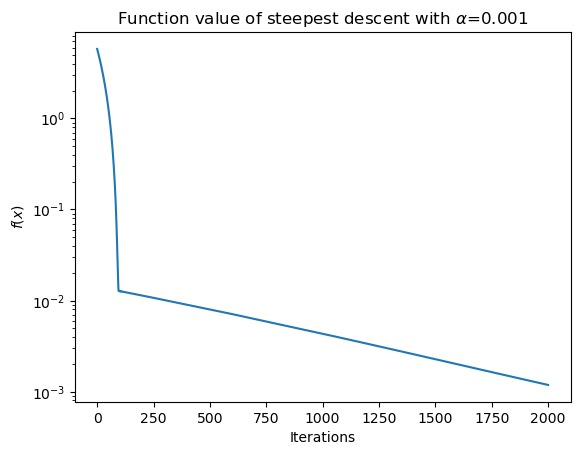

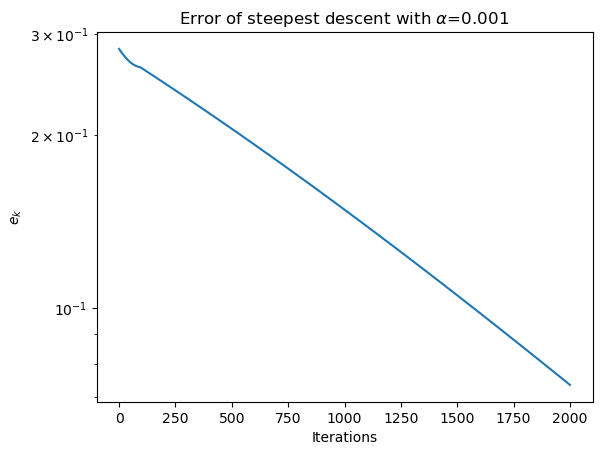

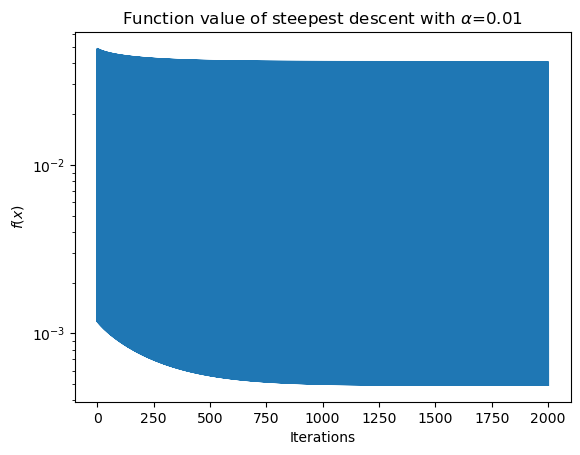

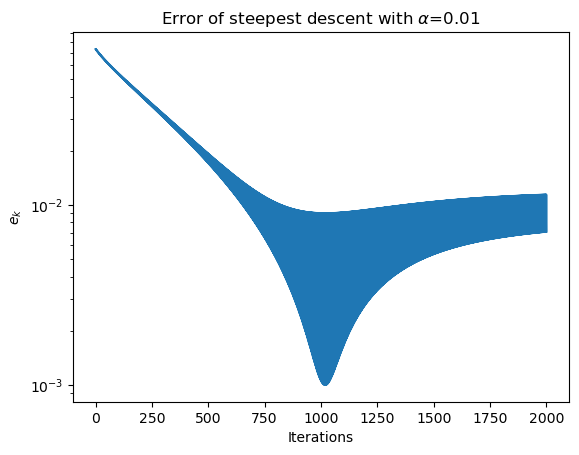

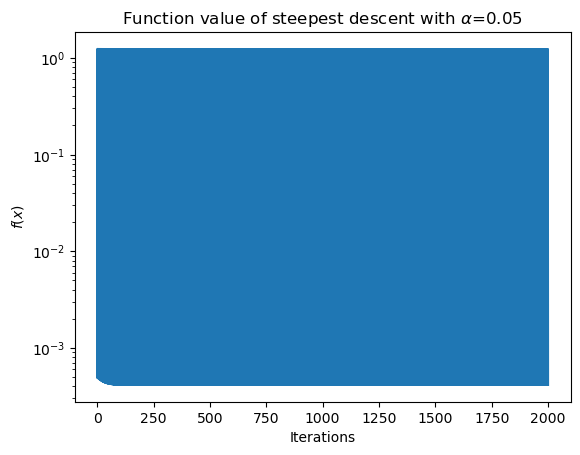

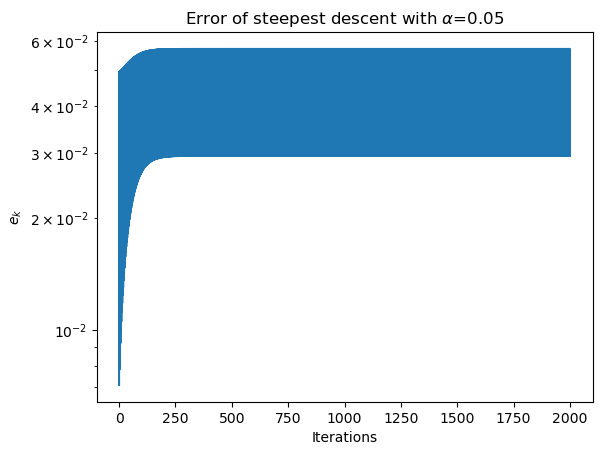

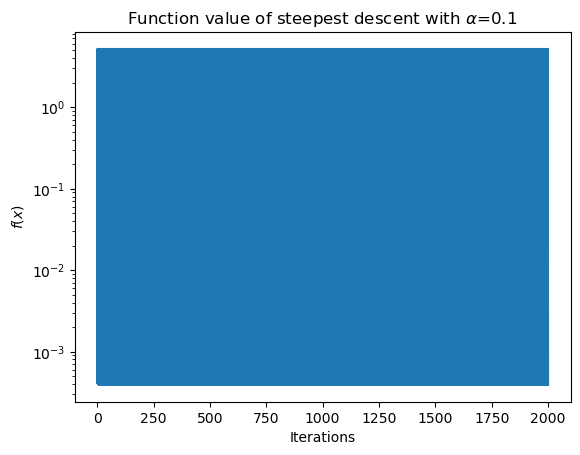

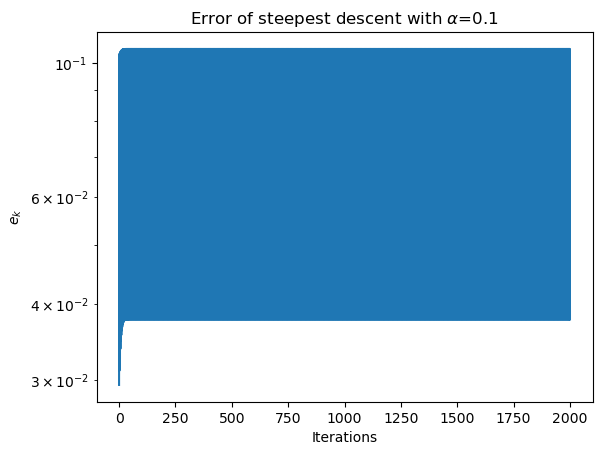

In [66]:
def steepest_descent(step_size: float, func: Callable, x0: Union[np.array, float], **kwargs):
    stats = {"converged": False,
             "function_calls": 1,
             "iterations": 0,
             "X": [],
             "F": [],
             "dF": [],
             "e": []}
    
    x = x0
    f, df, _ = func(x)
    
    x_star = np.array([1,1])
    
    
    stats["e"].append(np.linalg.norm(x-x_star))    
    stats["X"].append(x)
    stats["F"].append(f)
    stats["dF"].append(df)

    while (not stats["converged"] and stats["iterations"] < kwargs["max_iter"]):
        stats["iterations"] += 1
        
        x -= step_size * df / np.linalg.norm(df)
        
        f, df, _ = func(x)
        
        stats["converged"] = np.linalg.norm(df, ord=float("inf")) <= kwargs["tol"]
        stats["function_calls"] += 1
        
        stats["e"].append(np.linalg.norm(x-x_star))
        stats["X"].append(x)
        stats["F"].append(f)
        stats["dF"].append(df)
        
    return x, stats

x0 = np.array([1.2, 1.2])
tol = 1e-10
step_sizes = [0.001, 0.01, 0.05, 0.1]
for step_size in step_sizes:
    x, stats = steepest_descent(step_size, rosenbrock, x0, tol=tol, max_iter=2000)
    plt.semilogy(range(stats["iterations"]+1), stats["F"])
    plt.title(fr"Function value of steepest descent with $\alpha$={step_size}")
    plt.ylabel("$f(x)$")
    plt.xlabel("Iterations")
    plt.show()
    
    
    plt.semilogy(range(stats["iterations"]+1), stats["e"])
    plt.title(fr"Error of steepest descent with $\alpha$={step_size}")
    plt.ylabel("$e_k$")
    plt.xlabel("Iterations")
    plt.yscale("log")
    plt.show()
    plt.close()


In [74]:
rosenbrock_lambda = lambda x: 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
rosenbrock_grad_lambda = lambda x: np.array([-400*x[0]*(x[1] - x[0]**2) + 2 * x[0] - 2, 200*(x[1] - x[0] ** 2)])

def BFGS_line(x0: np.array, func: Callable, grad_f: Callable, iterations: int, **kwargs):
    """
    function must return (function value, gradient, hessian)
    """
    H = np.eye(len(x0))
    I = np.eye(len(x0))
    
    grad = grad_f(x0)
    
    x = x0
    
    xs = [x]
    ys = [func(x)]
    
    errors = [np.linalg.norm(x-kwargs["x_star"])]
    
    
    for k in range(iterations):
        grad = grad_f(x)
        
        
        p = -H @ grad
        
        
        alpha = backtrack(x, func, grad, p)
        
        next_x = x + alpha * p
        s = next_x - x
        y = grad_f(next_x) - grad
        
        if np.linalg.norm(grad, np.inf) <= kwargs["tol"]:
            break

        rho = 1 / np.dot(y, s)
        
        A = I - rho * np.outer(s, y)
        B = I - rho * np.outer(y, s)
        
        H = A @ H @ B + rho * np.outer(s, s)
        
        x = next_x
        
        xs.append(x)
        ys.append(func(x))
        errors.append(np.linalg.norm(x-kwargs["x_star"]))
    
    return xs, ys, errors
        
def backtrack(x, f, df, direction):
    alpha = 0.1
    c = 0.5
    rho = 0.8
    while f(x + alpha*direction) > (f(x) + c * alpha * df @ direction):
        alpha *= rho
    return alpha


x0 = np.array([1.2,1.2])
x, y, e = BFGS_line(x0, func=rosenbrock_lambda, grad_f=rosenbrock_grad_lambda, iterations=2000, x_star=np.array([1,1]), tol=1e-10)

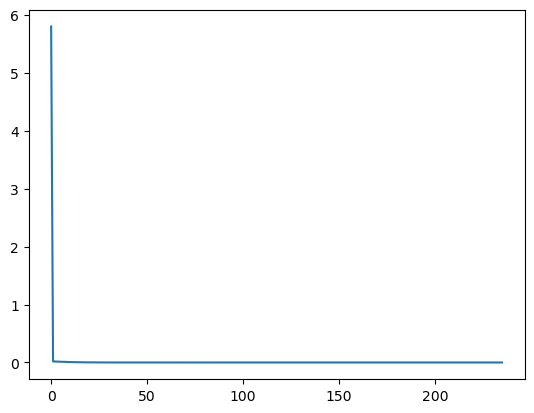

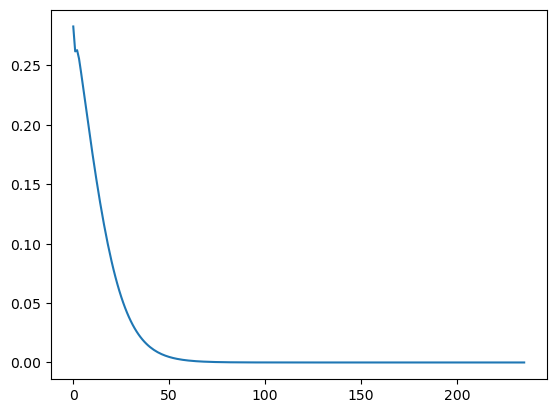

In [81]:
plt.plot(range(len(x)), y)
plt.show()

plt.plot(range(len(x)), e)
plt.show()

## Additional exercises

### 1 Convexity

We consider the function
$$f(x_1,x_2)=x_1x_2$$
on $\mathbb{R}_{++}^2$ and wish to determine whether it is convex or concave

We can determine this by computing the Hessian, starting with the gradient

$$\nabla f = \begin{bmatrix}x_2\\x_1\end{bmatrix}\\\nabla^2 f = \begin{bmatrix}0 & 1\\1&0\end{bmatrix}$$




In [94]:
x1 = sp.symbols("x_1")
x2 = sp.symbols("x_2")

mat = np.array([[0,1],[1,0]])
np.linalg.eig(mat)

(array([ 1., -1.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))